In [1]:
from brainways_lightning_module import BrainwaysLightningModule
from brainways_datamodule import BrainwaysDataModule
import torch
from single_dataset import BrainwaysSingleDataset
from lightning import Trainer
from dataset_utils import load_atlas_reference, transform_atlas_volume
from backbones.efficientnet_backbone import EfficientNetBackbone
import torch.utils.data
import numpy as np
from tqdm import tqdm

In [2]:
trainer = Trainer(precision="16-mixed")

with trainer.init_module(empty_init=True):
    transformed_atlases = {
        atlas_name: transform_atlas_volume(
            load_atlas_reference(atlas_name),
            transform=BrainwaysDataModule.define_eval_transform(),
        )
        for atlas_name in ["allen_mouse_25um"]
    }

    dataset = BrainwaysSingleDataset(
        data_sources=[
            {
                "images_path": "/home/ben/data/allen-resized",
                "labels_path": "/home/ben/python/brm2/data/allen/labels.csv",
                "atlas_name": "allen_mouse_25um",
                "type": "real",
            }
        ],
        transform=BrainwaysDataModule.define_eval_transform(),
    )
    model = BrainwaysLightningModule.load_from_checkpoint(
        "/home/ben/python/brm2/lightning_logs/version_226/checkpoints/epoch=0-step=45000.ckpt",
        backbone=EfficientNetBackbone(),
        pred_atlases=transformed_atlases,
    )
    model.freeze()
    model = model.model
    atlas_reference = model.get_atlas("allen_mouse_25um")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ben/miniconda3/envs/brm-dinov2/lib/python3.11/site-packages/lightning/pytorch/trainer/trainer.py:1106: `trainer.init_module` cannot fully support proper instantiation of your model with the `SingleDeviceStrategy` strategy. Please instantiate your model inside the`LightningModule.configure_model` hook instead
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)
INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpkz178k9h
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpkz178k9h/_remote_module_non_scriptable.py


In [3]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=128,
    num_workers=0,
    shuffle=False,
    pin_memory=True,
)

predictions = []
features = []
gt = []
filenames = []
for i, batch in enumerate(tqdm(dataloader)):
    batch_pred, batch_features = model.predict(batch["image"].to("cuda"), atlas_name="allen_mouse_25um", return_features=True)
    predictions.append(batch_pred.cpu().numpy())
    features.append(batch_features[:, :1280].cpu().numpy())
    gt.append(batch["ap"])
    filenames.append(batch["filename"])
predictions = np.concatenate(predictions)
features = np.concatenate(features)
gt = torch.cat(gt)
filenames = sum(filenames, [])

100%|██████████| 3479/3479 [1:11:01<00:00,  1.22s/it]


In [8]:
np.savez("cleanlab_inputs.npz", predictions=predictions, features=features, gt=gt.numpy(), filenames=filenames)

In [ ]:
cleanlab_inputs = np.load("cleanlab_inputs.npz")


In [6]:
len(filenames)

445258

In [5]:
l1 = np.abs(predictions - gt.numpy()).mean()
l1

6.5256413135755

In [12]:
# We'll assume your big arrays of labels, pred_probs have been saved to file like this:
from tempfile import mkdtemp
import os.path as path
from cleanlab.regression.filter import find_label_issues_batched

labels_file = path.join(mkdtemp(), "labels.npy")
pred_probs_file = path.join(mkdtemp(), "pred_probs.npy")
np.save(labels_file, gt.numpy())
np.save(pred_probs_file, predictions)

# Code to find label issues by loading data from file in batches:
from cleanlab.experimental.label_issues_batched import find_label_issues_batched

batch_size = 10000  # for efficiency, set this to as large of a value as your memory can handle

# Indices of examples with label issues, sorted by label quality score (most severe to least severe):
indices_of_examples_with_issues = find_label_issues_batched(
    labels_file=labels_file, pred_probs_file=pred_probs_file, batch_size=batch_size
)

IndexError: tuple index out of range

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


  0%|          | 0/20000 [00:00<?, ?it/s]


Audit complete. 1249 issues found in the dataset.
Here is a summary of the different kinds of issues found in the data:

    issue_type  num_issues
       outlier         860
         label         311
near_duplicate          59
         light          13
          dark           5
       non_iid           1

Dataset Information: num_examples: 20000


---------------------- outlier issues ----------------------

About this issue:
	Examples that are very different from the rest of the dataset 
    (i.e. potentially out-of-distribution or rare/anomalous instances).
    

Number of examples with this issue: 860
Overall dataset quality in terms of this issue: 0.3724

Examples representing most severe instances of this issue:
       is_outlier_issue  outlier_score
12042              True   2.012204e-22
5300               True   5.847775e-20
12459              True   2.898253e-18
6023               True   1.624535e-16
12068              True   1.367473e-13


----------------------- label is

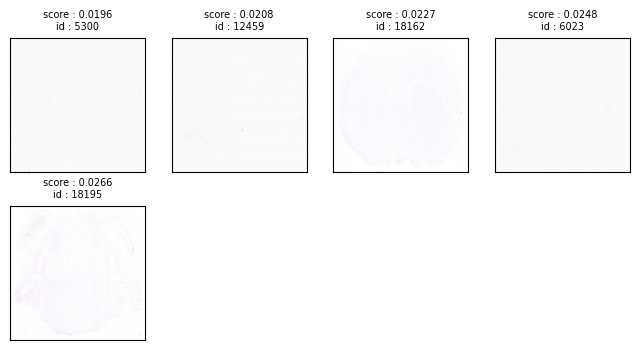

----------------------- dark images ------------------------

Number of examples with this issue: 5
Examples representing most severe instances of this issue:



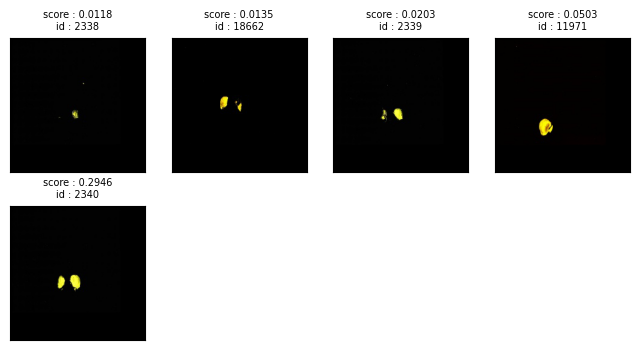

In [14]:
from cleanlab import Datalab
from datasets import Dataset, Image

datalab_dataset = Dataset.from_dict({
    "image": filenames,
    "label": gt.tolist(),
}).cast_column("image", Image())

indices = np.arange(0, 20000)
datalab_dataset_batch = datalab_dataset.select(indices)

# Assuming your dataset has a label column named 'label'
lab = Datalab(datalab_dataset_batch, label_name="label", task="regression", image_key="image")
# To detect more data issue types, optionally supply `features` (numeric dataset values or model embeddings of the data)
lab.find_issues(pred_probs=predictions[indices], features=features[indices])

lab.report()

In [ ]:
import math
import matplotlib.pyplot as plt

def plot_indices(indices: list[int]):
    num_examples = len(indices)
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()

    for i, ax in enumerate(axes_list):
        if i >= num_examples:
            ax.axis("off")
            continue
        idx = int(indices[i])
        ax.set_title(
            f"id: {idx}\n GL: {int(gt[i])}\n SL: {int(predictions[i])}",
            fontdict={"fontsize": 8},
        )
        image = dataset[idx]["image"][1]
        gt_atlas_slice = atlas_reference[int(dataset[idx]["ap"]), 1].cpu()
        pred_atlas_slice = atlas_reference[min(int(predictions[idx]), 527), 1].cpu()

        # Concatenate the images along the second axis (side by side)
        combined_image = np.concatenate((image, gt_atlas_slice, pred_atlas_slice), axis=1)

        ax.imshow(combined_image, cmap="gray")
        ax.axis("off")
    plt.subplots_adjust(hspace=0.7)
    plt.show()

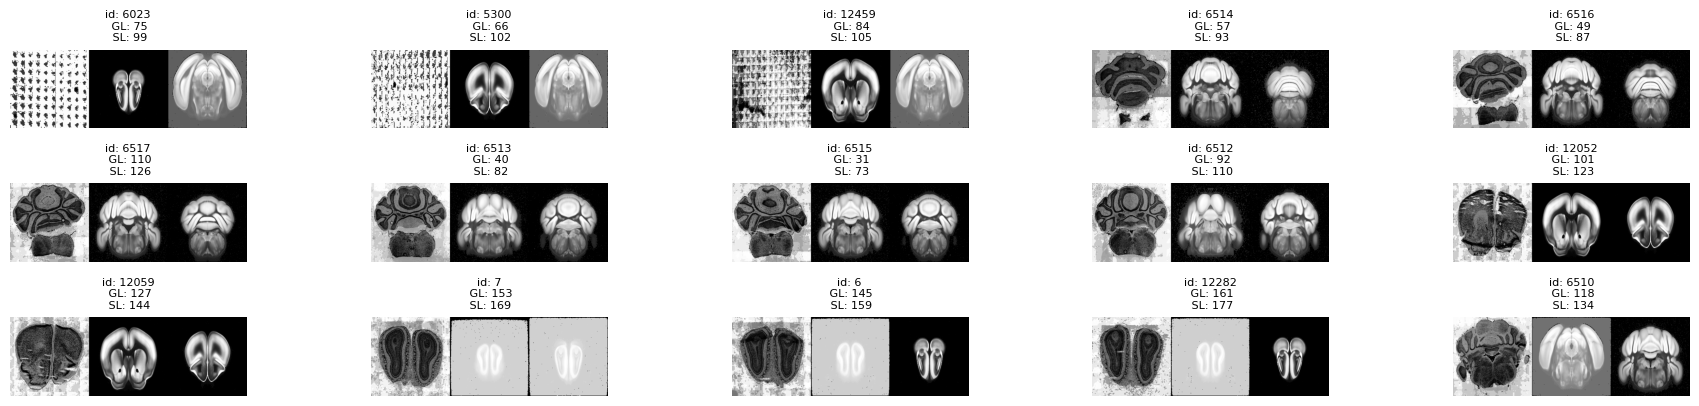

In [ ]:
num_examples = 15
label_issues = lab.get_issues("label")
label_issues.head()

label_issues_df = label_issues.query("is_label_issue").sort_values("label_score")
label_issue_indices = label_issues_df.index.values[:num_examples]
plot_indices(label_issue_indices)

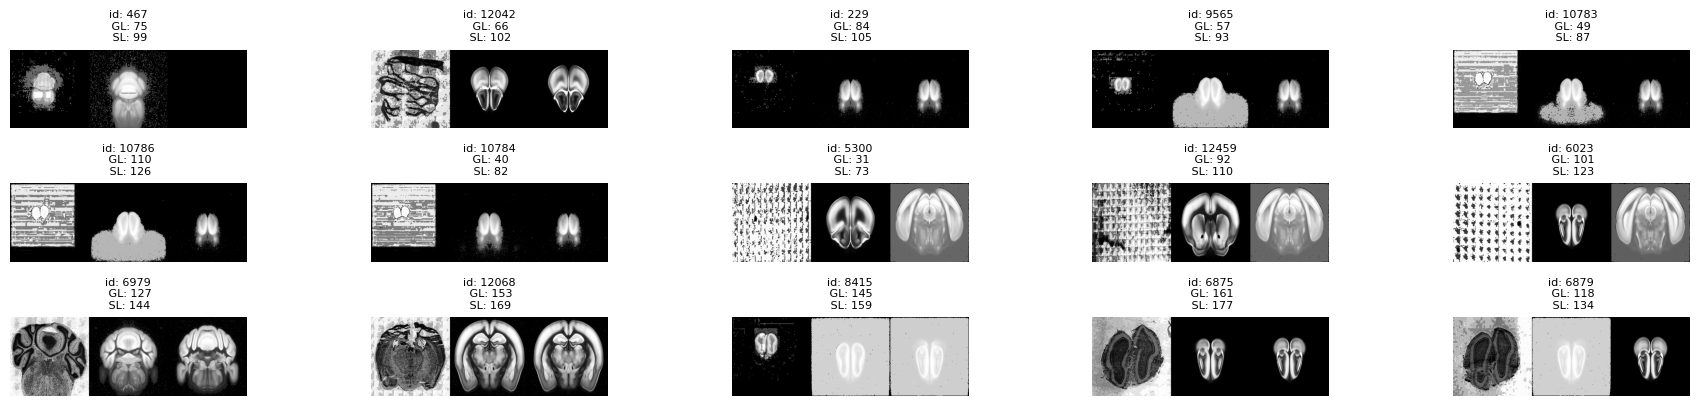

In [ ]:
outlier_issues_df = lab.get_issues("outlier")
outlier_issues_df = outlier_issues_df.query("is_outlier_issue").sort_values("outlier_score")
outlier_issues_indices = outlier_issues_df.index.values[:num_examples]
plot_indices(outlier_issues_indices)